In [14]:
from math import log
from operator import itemgetter
import numpy as np

def readData(filename):
    dataSet = []
    with open(filename,encoding='utf-8') as f:
        for line in f:
            x1,x2,y=line.strip().split(" ")
            dataSet.append([x1,x2,y])
    f.close()
    labels = ['Xn1','Xn2']

    return dataSet, labels

def calculateEntropy(dataSet,index): 
    # calculate the Shannon entropy
    entropy = 0.0
    targetSet = [data[index] for data in dataSet] 
    instances = set(targetSet)
    
    for value in instances:
        prob = targetSet.count(value)/len(dataSet)
        entropy -= prob * (log(prob)/log(2))
        
    return entropy

def detemineCandidateNumericSplits(dataSet,index):
    '''
    Given a dataset D and a specific feature index to sort the values of Xi in D 
    Evaluate split thresholds in intervals between instances of different classes
    
    return the candidate splits
    '''
    C = []
    sortedData = sorted(dataSet, key = itemgetter(index))
    previousLabel = ''
    for data in sortedData:
        if(previousLabel == ''): 
            previousLabel = data[-1]
        else:
            if(data[-1] != previousLabel):
                previousLabel = data[-1]
                C.append(data[index]) 
    return C
            
def splitDataSet(dataSet, index, value, mode):
    # index : split the dataset according to the ith feature
    # value : given the selected feature, split the dataset with respect to the value
    # mode : 
    # 1 - split data with feature greater or equal to value
    # 2 - less than the value
    # 3 - equal to the value
   
    feature = []
    subDataSet = []
    if(mode == 1):
        for feature in dataSet:
            if feature[index] >= value: 
                subDataSet.append(feature[:])
    elif(mode == 2):
        for feature in dataSet:
            if feature[index] < value: 
                subDataSet.append(feature[:])
    elif(mode == 3):
        for feature in dataSet:
            if feature[index] == value: 
                subDataSet.append(feature[:])
                
    return subDataSet

def findBestSplit(dataSet):
    # find the split with largest info gain ratio from the candidate splits
    feature = len(dataSet[0]) - 1  # ith feature
    entropy = calculateEntropy(dataSet,-1)
    bestInfoGainRatio = 0.0
    bestFeatureIndex = -1
    bestValue = 0.0
    for i in range(feature):  # for every feature
        candidate = detemineCandidateNumericSplits(dataSet, i)
    
        for value in candidate: # calculate info gain ratio for the value in our candidate set
            
            conditionalEntropy = 0.0
            entropy_value = 0.0  # entropy of split the data with ith feature and value
            
            subDataSet_1 = splitDataSet(dataSet, i, value, mode = 1) # sub dataset with ith feature >= value       
            subDataSet_2 = splitDataSet(dataSet, i, value, mode = 2) # sub dataset with ith feature < value
           
            if(len(subDataSet_1)!=0 and len(subDataSet_2)!=0): # avoid the math domain error (prob == 0) 
                # probability of ith feature >= certain value
                prob_1 = len(subDataSet_1) / float(len(dataSet)) 
                # probability of ith feature < certain value
                prob_2 = len(subDataSet_2) / float(len(dataSet)) 

                conditionalEntropy = prob_1 * calculateEntropy(subDataSet_1,-1)
                conditionalEntropy += prob_2 * calculateEntropy(subDataSet_2,-1)

                entropy_value = -prob_1 * (log(prob_1)/log(2))
                entropy_value += -prob_2 * (log(prob_2)/log(2))

                infoGain = entropy - conditionalEntropy
                infoGainRatio = infoGain/entropy_value

                if (infoGainRatio > bestInfoGainRatio): 
                    bestInfoGainRatio = infoGainRatio
                    bestFeatureIndex = i
                    bestValue = value

    return bestFeatureIndex, bestValue

def majorityCount(classList):
    # count the majority label in a given dataset
    # the label appeared most frequently
    classCount = {}
    for data in classList:
        if data not in classCount.keys(): 
            classCount[data] = 0
        classCount[data] += 1
    sortedClassCount = sorted(classCount.items(),key=itemgetter(1), reverse=True)
    
    return sortedClassCount

def createTree(dataSet, labels):
    #main function to create decision tree
    
    bestFeature, bestValue = findBestSplit(dataSet) 
    classList = [data[-1] for data in dataSet] 
    
    if(len(dataSet) == 0):
        return
    elif(bestFeature == -1):
        sortedClassCount = majorityCount(classList)
        if(len(sortedClassCount) == 2 and sortedClassCount[0][1] == sortedClassCount[1][1]):
            return '1'
        else:
            return sortedClassCount[0][0]
    
    bestFeatureLabel = labels[bestFeature]
    myTree = {bestFeatureLabel: {}}

    myTree[bestFeatureLabel]['>=' + bestValue] = createTree(splitDataSet(dataSet, bestFeature, bestValue, mode = 1), labels)
    myTree[bestFeatureLabel]['<' + bestValue] = createTree(splitDataSet(dataSet, bestFeature, bestValue, mode = 2), labels)
    return myTree


dataSet, labels = readData('data/D3Leaves.txt')
tree = createTree(dataSet,labels)

In [ ]:
# another way to visualize the decision tree
# it may be easier to use it when you are using cloud platform like google colab
import pydot

def draw(parentName, childName):
    edge = pydot.Edge(parentName, childName)
    graph.add_edge(edge)
    
def visit(node, parent=None):
    for m,n in node.items():
        if isinstance(n, dict):
            # start with the root node whose parent is None
            if parent:
                draw(parent, m)
            visit(n, m)
        else:
            draw(parent, m)
            # drawing the label using a distinct name
            draw(m, m + '\n' + 'label: '+n)

graph = pydot.Dot(graph_type='graph')
visit(tree)
graph.write_png('output.png')

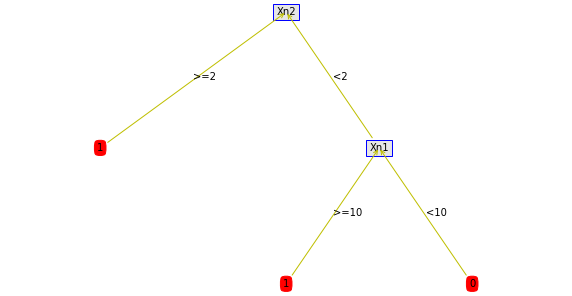

In [15]:
import matplotlib.pyplot as plt
 
# Define the shape of the node
decisionNode = dict(boxstyle="square", color='b', fc='0.9')
# Defining leaf node shapes
leafNode = dict(boxstyle="round4", color='r')
# Define the shape of the arrow of the parent node pointing to the child node or leaf
arrow_args = dict(arrowstyle="->", color='y')
 
def plot_node(node_txt, center_point, parent_point, node_style):
    '''
    Draw the parent-child node, the arrow between the nodes, and fill the text on the middle of the arrow
    :param node_txt: content of txt
    :param center_point: the mid point of txt
    :param parent_point: point to the center of the text
    '''
    createPlot.ax1.annotate(node_txt, xy=parent_point, xycoords='axes fraction', xytext=center_point,
                            textcoords='axes fraction', va="center", ha="center", bbox=node_style,
                            arrowprops=arrow_args)
 
def get_leafs_num(tree_dict):
    '''
    Get the number of leaf nodes
    :param tree_dict: data dictionary for trees
    :return total number of leaf nodes of tree_dict
    '''

    leafs_num = 0
    
    root = list(tree_dict.keys())[0]
    child_tree_dict =tree_dict[root]
    
    for key in child_tree_dict.keys():
        if type(child_tree_dict[key]).__name__=='dict':
            # If the subtree is a dict type, 
            # the number of leaf nodes of the current tree plus the number of leaf nodes of this subtree
            leafs_num += get_leafs_num(child_tree_dict[key])
        else:
            # If the subtree is not a dict form, 
            # add 1 to the number of leaf nodes in the current tree
            leafs_num += 1
 
    return leafs_num
 
def get_tree_max_depth(tree_dict):
    
    max_depth = 0
    root = list(tree_dict.keys())[0]
    child_tree_dict = tree_dict[root]
    
    for key in child_tree_dict.keys():    
        this_path_depth = 0    
        if type(child_tree_dict[key]).__name__ == 'dict':   
            this_path_depth = 1 + get_tree_max_depth(child_tree_dict[key])
        else:
            this_path_depth = 1
        if this_path_depth > max_depth:
            max_depth = this_path_depth
    
    return max_depth
 
def plot_mid_text(center_point, parent_point, txt_str):
    '''
    Calculate the middle position of the parent and child nodes 
    and fill the text information between the parent and child nodes
    :param center_point: center point of txt
    :param parent_point: point to the point at the center of the text
    '''
    
    x_mid = (parent_point[0] - center_point[0])/2.0 + center_point[0]
    y_mid = (parent_point[1] - center_point[1])/2.0 + center_point[1]
    createPlot.ax1.text(x_mid, y_mid, txt_str)
    return
 
def plotTree(tree_dict, parent_point, node_txt):

    leafs_num = get_leafs_num(tree_dict)
    root = list(tree_dict.keys())[0]
    # plotTree.totalW indicates the depth of the tree
    center_point = (plotTree.xOff+(1.0+float(leafs_num))/2.0/plotTree.totalW,plotTree.yOff)
    # Fill node_txt content
    plot_mid_text(center_point, parent_point, node_txt)
    # drawing the content on arrows
    plot_node(root, center_point, parent_point, decisionNode)
    # child tree
    child_tree_dict = tree_dict[root]
    plotTree.yOff=plotTree.yOff-1.0/plotTree.totalD
    # Since the tree is drawn from top to bottom 
    # the y-coordinate values need to be decremented in order
    # and plotTree.totalD indicates the depth of the stored tree
    for key in child_tree_dict.keys():
        if type(child_tree_dict[key]).__name__ == 'dict':
            plotTree(child_tree_dict[key],center_point,str(key))
        else:
            plotTree.xOff=plotTree.xOff+1.0/plotTree.totalW
            plot_node(child_tree_dict[key],(plotTree.xOff,plotTree.yOff),center_point,leafNode)
            plot_mid_text((plotTree.xOff,plotTree.yOff),center_point,str(key))
    # After drawing all child nodes, increase the offset of the global variable Y
    plotTree.yOff=plotTree.yOff+1.0/plotTree.totalD
 
    return
 
def createPlot(tree_dict):

    # background color
    fig=plt.figure(1 ,facecolor='white',figsize = (10,5))
    # clear
    fig.clf()
    # Define the horizontal and vertical axes
    # and be careful not to set the values of xticks and yticks
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1=plt.subplot(111, frameon=False, **axprops)
    
    # The global variable createPlot.ax1 defines a plotting area
    # 111 means the first row and column
    # frameon means the border
    # **axprops does not show the scale
    plotTree.totalW=float(get_leafs_num(tree_dict))
    plotTree.totalD=float(get_tree_max_depth(tree_dict))
    plotTree.xOff=-0.5/plotTree.totalW;
    plotTree.yOff=1.0;
    plotTree(tree_dict, (0.5,1.0), '')
    plt.show()
    
createPlot(tree)